In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import main 

In [2]:
## index finder 
class ImpreciseString(Exception):
    def __init__(self, msg):
        self.message = msg

def StringIndexFinder(samplefile, string_list):
    """
    This function takes a data file and a list of strings. It then iterates over all lines in that file, searching for
    any occurances of the given strings in the list. if the string is found, the index of the line is saved to a
    dictionary. if there are more than one occurances, it raises an exception.
    
    returns: dictionary of the strings and the index where they were found
    """
    with open(samplefile, 'r') as f:  # read the samplefile
        data = f.readlines()
    
    indices = {}
    for i in data:  
        for j in string_list:
            if(i.rfind(j)>=0):  # find given string in line of document
                if(j in indices.keys()):  # if the entry in the document already exists, raise exception
                    raise ImpreciseString("String already in dict - too many values found.")
                else:
                    index = data.index(i)
                    indices[j] = index
    return indices

In [118]:
filelist = sorted(os.listdir('/home/corvus/code/mpia_local/data'))
loc = '/home/corvus/code/mpia_local/data/'  # absolute path to the data directory
plot_loc = '/home/corvus/code/mpia_local/planet_plots/'

#### Initial coordinate extraction (these index values are hard coded for laziness reasons): 
# reading the first file
with open(loc+filelist[0], 'r') as f:
    data = f.readlines()
    
#### Extraction:
# search strings:
search_list = ['I, R[cm]', 'J, THETA[0-pi]', 'K, PHI[0-2pi]', '< --radial number of Gridcells', 
               '< --polar number of Gridcells', '< --azimuthal number of Gridcells', ' Pl.-mass(Mstar)', ' Data: ',
              ' min. and max. temp. [K]:', ' min. and max. density[g/cm^3]:', 'VPHI-VKEP', ' Mstar']

inDict = StringIndexFinder(loc+filelist[0], search_list)

# the data slice in the first for-loop in the 3 bigger loops 'Radius', 'Polar angle' and 'Azimuthal angle' look 
# really bad. But, they wort automatically. The StringIndexFinder gets the line of the crucial parts and with a bit
# of tweaking (.strip().split()) and typecasting to int we're good to go. yay, scientific data analysis! 

# Radius
radius = []  # list of lists: [number of cell, center coordinate, interface coordinate]
for i in data[inDict['I, R[cm]']+1:inDict['I, R[cm]']+
              int(data[inDict['< --radial number of Gridcells']].strip().split()[0])+1]:
    i = i.strip().split()
    i[0] = int(i[0])
    i[1] = float(i[1])
    i[2] = float(i[2])
    radius.append(i)
radius = np.array(radius)

# Polar angle
polar = []  # list of list: [number of cell, center coordinate, interface coordinate]
for i in data[inDict['J, THETA[0-pi]']+1:inDict['J, THETA[0-pi]']+
              int(data[inDict['< --polar number of Gridcells']].strip().split()[0])+1]:
    i = i.strip().split()
    i[0] = int(i[0])
    i[1] = float(i[1])
    i[2] = float(i[2])
    polar.append(i)
polar = np.array(polar)

# Azimuthal angle
azimuth = []  # list of list: [number of cell, center coordinate, interface coordinate]
for i in data[inDict['K, PHI[0-2pi]']+1:inDict['K, PHI[0-2pi]']+
              int(data[inDict['< --azimuthal number of Gridcells']].strip().split()[0])+1]:
    i = i.strip().split()
    i[0] = int(i[0])-1  # the cell number starts with 2 in the file, which is obviously wrong
    i[1] = float(i[1])
    i[2] = float(i[2])
    azimuth.append(i)
azimuth = np.array(azimuth)

#### Planet location
# location is at: 5.0000000000000003E-002 * AU
AU = 14959787069100  # 1 AU in cm
planet_loc = -5.0000000000000003E-002 * AU  # planet location in x-direction
grav_const = 6.674E-8  # cm^3 g^-1 s^-2

#### Hill sphere (roche sphere):
# semi major axis is the distance from the star to the planet = planet_loc 
# and the mass of the planet is given in star-masses
m_star = float(data[inDict[' Mstar']].strip().split()[0])  # in g
m_planet = float(data[inDict[' Pl.-mass(Mstar)']+1].strip().split()[0])  # in star masses
r_hill = np.abs(planet_loc)*((m_planet/3)**(1/3))
r0_planet = 6.37814E8 * 2  # 2x Earth radius

# update the parameter dictionary from the 'main' file
main.params['planet_location_x'] = planet_loc
main.params['r_hill'] = r_hill
main.params['r0_planet'] = r0_planet
main.params['box'] = 1747428242.0
main.params['delta'] = [0.1]

# setting the 3 parameters for the shell extractor
shell = main.params['r_hill']
delta = main.params['delta']
box = main.params['box']

# ToDo: redo all these values because they are faulty!
# max and min vr, found by looping over all files and finding min/max values for vr
#vr_max = 0
#vr_min = 0
#vr_levels = ([np.round(i, -3) for i in np.linspace(vr_min, 0, 50)] + # negative part
#        [np.round(i, -3) for i in np.linspace(0, vr_max, 50)][1:])   # positive part

# max and min radial radiation flux 
#fluxr_min = 0
#fluxr_max = 0
#fluxr_levels = [np.round(i, 19) for i in np.linspace(fluxr_min, fluxr_max, 100)]

# max and min contour level for temperature plot
tContour_min = 0.02e4
tContour_max = 1.2e4
#t_levels = [np.round(i,-1) for i in np.linspace(tContour_min, tContour_max, 10)]

# max and min contour level for density plot
rhoContour_min = 0.2e3
rhoContour_max = 1.25e3
rho_levels = [np.round(i,-1) for i in np.linspace(rhoContour_min, rhoContour_max, 6)]

# max and min contour level for mass flux
#mfluxr_min = 0
#mfluxr_max = 0
#mfluxr_levels = ([np.round(i, 11) for i in np.linspace(mfluxr_min, 0, 15)] + # negative part
#           [np.round(i, 11) for i in np.linspace(0, mfluxr_max, 15)][1:])   # positive part

#### Coordinate Transformation
r_plan, theta_plan, phi_plan = main.coordinate_trafo(radius.T[1], polar.T[1], azimuth.T[1], plan_loc_x=planet_loc)

#### spherical coordinates to cartesian coordinates for vectorfield plot
print("\n:: Calculating the cartesian coordinates for the planet's coordinate system for the vectorfield plot")
PLANET_RADIUS = r0_planet  # default radius
HILL_SPHERE = r_hill
x_plan, y_plan, z_plan = main.cartesian_coord_planet(radius.T[1], polar.T[1], azimuth.T[1], plan_loc_x=planet_loc)

print('\n:: Slicing the dataset.')
dataset = np.array([x_plan, y_plan, z_plan])
indices_vec = [i for i,j in enumerate(dataset.T) if np.abs(j[0]) <= 2*HILL_SPHERE  # x-condition
                                                 if np.abs(j[1]) <= 2*HILL_SPHERE  # y-condition
                                                 if np.abs(j[2]) <= PLANET_RADIUS]  # z-condition
print('\n:: Number of values found: ', len(indices_vec), '\n')
dataset_sliced = dataset.T[indices_vec]

#print(np.max(radius.T[1,1:]-radius.T[1,:-1]))


:: Calculating the cartesian coordinates for the planet's coordinate system for the vectorfield plot

:: Slicing the dataset.

:: Number of values found:  1249 



In [4]:
##### PRE-RUN to get the minimum/maximum values for the color-bars / the plot axis

# initial values
temp_min = 300  # as the absolute minimum is 0, we better start at a higher temp..
temp_max = 0
rho_min = 10  # same reason as above .. 
rho_max = 0
vr_max = 0
vr_min = 0
mfluxr_max = 0
mfluxr_min = 0
fluxr_min = 0
fluxr_max = 0
rho_hill_min = 10
rho_hill_max = 0

print(':: first we need to find out the min and max values for the datasets, so this is a mere informative run.\n')
for file in filelist:
    print("\n:: Starting informative routine for file: "+file)
    #### Read the snapshot file
    with open(loc+file, 'r') as f:
        data = f.readlines()
    
    #### initialize the empty data lists and fill in the data values
    radii_index = []
    velocities = []
    flux = []
    rho = []

    # min / max temp:
    templist = data[inDict[' min. and max. temp. [K]:']+1].strip().split()
    
    if(float(templist[0])<temp_min):
        temp_min=float(templist[0])
        
    if(float(templist[1])>temp_max):  
        temp_max=float(templist[1])
    
    # min / max density:
    rholist = data[inDict[' min. and max. density[g/cm^3]:']+1].strip().split()
    
    if(float(rholist[0])<rho_min):
        rho_min=float(rholist[0])
    
    if(float(rholist[1])>rho_max):
        rho_max=float(rholist[1])
    
    # Extraction:
    for cell in data[inDict[' Data: ']+1:-1]:
        cell = cell.strip().split()
        if('VPHI-VKEP' not in inDict.keys()):
            radii_index.append(int(cell[0]))  # append the number of the box to the list for keplarian speed calc
        rho.append(float(cell[3]))
        velocities.append([float(i) for i in cell[6:9]])
        flux.append([float(i) for i in cell[9:]])

    # generating numpy arrays
    velocities = np.array(velocities)
    flux = np.array(flux)
    rho = np.array(rho)
    
    # subtract v_kepler, if not already done
    if('VPHI-VKEP' not in inDict.keys()):
        for i,j in enumerate(radii_index):
            velocities.T[2,i] = velocities.T[2,i] - np.sqrt(grav_const*m_star/radius.T[1,j-1])  
    
    #### radial velocity in a shell around the hill sphere 
    # velocities
    # transformation
    vr_plan, vtheta_plan, vphi_plan = main.velocity_trafo(velocities.T[0], velocities.T[1], velocities.T[2],
                                                         radius.T[1], polar.T[1], azimuth.T[1],
                                                         r_plan, theta_plan, phi_plan)
    # extracted velocities and indices
    vels, indices = main.extract_shell(vr_plan, vtheta_plan, vphi_plan, r_plan, 
                                       shell=shell, delta=delta, box=box)
    
    if(vels[0].max() > vr_max):
        vr_max = vels[0].max()
    if(vels[0].min() < vr_min):
        vr_min = vels[0].min()
                     
            
    #### radial massflux onto/from the shell around the hill sphere
    # since the density is a scalar value, we can just multiply it with v_R (using the correct indices)
    mfluxes = rho[indices]*vels
    
    if(mfluxes[0].max() > mfluxr_max):
        mfluxr_max = mfluxes[0].max()
                                                                   
    if(mfluxes[0].min() < mfluxr_min):
        mfluxr_min = mfluxes[0].min()
    
    
    #### radial radiation flux onto/from the shell around the hill sphere
    # radiation flux
    # transformation
    fluxr_plan, fluxtheta_plan, fluxphi_plan = main.velocity_trafo(flux.T[0], flux.T[1], flux.T[2],
                                                                   radius.T[1], polar.T[1], azimuth.T[1],
                                                                   r_plan, theta_plan, phi_plan)
    
    # extracted flux and indices
    fluxes, indices = main.extract_shell(fluxr_plan, fluxtheta_plan, fluxphi_plan, r_plan, 
                                         shell=shell, delta=delta, box=box)
    
    if(fluxes[0].max() > fluxr_max):
        fluxr_max = fluxes[0].max()
                                                                   
    if(fluxes[0].min() < fluxr_min):
        fluxr_min = fluxes[0].min()
    
    # extracted density 
    if(rho[indices].max() > rho_hill_max):
        rho_hill_max = rho[indices].max()
    
    if(rho[indices].min() < rho_hill_min):
        rho_hill_min = rho[indices].min()

#### setting the ranges
# vr
vr_levels = ([np.round(i, -3) for i in np.linspace(vr_min, 0, 50)] + # negative part
        [np.round(i, -3) for i in np.linspace(0, vr_max, 50)][1:])   # positive part

# mass flux
mfluxr_levels = ([np.round(i, 11) for i in np.linspace(mfluxr_min, 0, 15)] + # negative part
           [np.round(i, 11) for i in np.linspace(0, mfluxr_max, 15)][1:])   # positive part
                     
# radiation flux
fluxr_levels = ([np.round(i, 19) for i in np.linspace(fluxr_min, 0, 15)] + # negative part
           [np.round(i, 19) for i in np.linspace(0, fluxr_max, 15)][1:])   # positive part

# density in hill sphere
rho_hill_levels = [np.round(i,9) for i in np.linspace(rho_hill_min, rho_hill_max, 30)]
                     
print("::Finished setting the plotting range values\n")

:: first we need to find out the min and max values for the datasets, so this is a mere informative run.


:: Starting informative routine for file: PLANET3D.000

:: Shell Extractor:
:: Number of Values in shell: 280 


:: Shell Extractor:
:: Number of Values in shell: 280 


:: Starting informative routine for file: PLANET3D.001

:: Shell Extractor:
:: Number of Values in shell: 280 


:: Shell Extractor:
:: Number of Values in shell: 280 


:: Starting informative routine for file: PLANET3D.002

:: Shell Extractor:
:: Number of Values in shell: 280 


:: Shell Extractor:
:: Number of Values in shell: 280 


:: Starting informative routine for file: PLANET3D.003

:: Shell Extractor:
:: Number of Values in shell: 280 


:: Shell Extractor:
:: Number of Values in shell: 280 


:: Starting informative routine for file: PLANET3D.004

:: Shell Extractor:
:: Number of Values in shell: 280 


:: Shell Extractor:
:: Number of Values in shell: 280 


:: Starting informative routine for file: P

In [120]:
for file in filelist:
#for file in filelist[:1]:  # just one file for testing reasons - don't forget to change this later!
    print("\n:: Starting plotting routine for file: "+file)
    #### Read the snapshot file
    with open(loc+file, 'r') as f:
        data = f.readlines()
        
    #### create signature with timestamp + filename for the plots
    sign = file.split(sep='.')[1] + "_" + main.timestamp()  # using the number of the plot as leading numer
    
    #### initialize the empty data lists and fill in the data values
    radii_index =[]
    rho = []
    temp = []
    velocities = []
    flux = []

    # Extraction:
    for cell in data[inDict[' Data: ']+1:-1]:
        cell = cell.strip().split()
        if('VPHI-VKEP' not in inDict.keys()):
            radii_index.append(int(cell[0]))  # append the number of the box to the list for keplarian speed calc
        rho.append(float(cell[3]))
        temp.append(float(cell[4]))
        velocities.append([float(i) for i in cell[6:9]])
        flux.append([float(i) for i in cell[9:]])

    # generating numpy arrays
    rho = np.array(rho)
    temp = np.array(temp)
    velocities = np.array(velocities)
    flux = np.array(flux)
    
    # subtract v_kepler, if not already done
    if('VPHI-VKEP' not in inDict.keys()):
        for i,j in enumerate(radii_index):
            velocities.T[2,i] = velocities.T[2,i] - np.sqrt(grav_const*m_star/radius.T[1,j-1])
    
    print(":: Data extraction complete. starting plots now...")
    """
    #### temperature, density over R plots 
    # temperature
    fig, ax, cax = main.scatter_contour(r_plan, temp, x_norm=r0_planet, xlog=True)
    ax.set_xlabel('$\mathrm{log}\ R/R_P$')
    ax.set_ylabel('Temperature $\mathrm{[K]}$')
    ax.set_title('Temperature Plot | Snapshot: '+file)
    #ax.set_xscale('log')
    ax.set_xlim(1e-1, 2e2)  # cosmetics
    ax.set_ylim(temp_min, temp_max)
    fig.savefig(plot_loc + sign + '_temp.png', format='png')
    plt.close(fig)
    
    # density
    fig, ax, cax = main.scatter_contour(r_plan, rho, x_norm=r0_planet, xlog=True, nbins=1000, num_levels=10)
    ax.set_yscale('log')
    ax.set_xlabel('$\mathrm{log}\ R/R_P$')
    ax.set_ylabel('Density $\mathrm{[\\frac{g}{cm^3}]}$')
    ax.set_title('Density Plot | Snapshot: '+file)
    ax.set_xlim(1e0, 2e3)  # cosmetics
    ax.set_ylim(rho_min, rho_max)
    fig.savefig(plot_loc + sign + '_density.png', format='png')
    plt.close(fig)
    print(":: Temperature and density plots: [done]")
    """
    print(":: Testing for density plots...")
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111)

    counts, xed, yed, image = ax.hist2d(np.log10(r_plan/r0_planet), np.log10(rho), bins=50, 
                                        cmap='seismic', range=[[0,2.2], [-26, -4]], cmin=1, alpha=0)
    ax.scatter(np.log10(r_plan/r0_planet), np.log10(rho), c='g', edgecolors='face', s=15, marker='.', alpha=0.2)
    con = ax.contour(counts.T, levels=rho_levels, extent=[xed.min(), xed.max(), yed.min(), yed.max()], linewidths=3, 
                     cmap='seismic', alpha=1)

    cb = plt.colorbar(con, fraction=0.046, pad=0.04, orientation='vertical')
    cb.formatter.set_powerlimits((0,0))  # setting the scientific notation of the color bar ticks
    cb.update_ticks()

    fig.canvas.draw()
    xmajorLocator = mtick.MultipleLocator(1)
    ax.xaxis.set_major_locator(xmajorLocator)
    labels_test = ['10e0', '$10^0$','$10^1$', '$10^2$']
    ax.xaxis.set_major_formatter(mtick.FixedFormatter(labels_test))
    ymajorLocator = mtick.MultipleLocator(5)
    ax.yaxis.set_major_locator(ymajorLocator)
    ylabels = ['10e-25', '$10^{-25}$', '$10^{-20}$', '$10^{-15}$', '$10^{-10}$', '$10^{-5}$']
    ax.yaxis.set_major_formatter(mtick.FixedFormatter(ylabels))

    ax.set_ylabel('$\\varrho\ [\\mathrm{g/cm^3}]$', fontsize=12)
    ax.set_xlabel('$\\mathrm{log}\ \\frac{R}{R_P}$', fontsize=12)
    ax.set_title('Density Contour | Snapshot: ' + file)

    fig.savefig(plot_loc + sign + '_density.png', format='png')
    plt.close(fig)
    """
    #### radial velocity in a shell around the hill sphere contour plot with hammer projection 
    # velocities
    # transformation
    vr_plan, vtheta_plan, vphi_plan = main.velocity_trafo(velocities.T[0], velocities.T[1], velocities.T[2],
                                                         radius.T[1], polar.T[1], azimuth.T[1],
                                                         r_plan, theta_plan, phi_plan)
    # extracted velocities and indices
    vels, indices = main.extract_shell(vr_plan, vtheta_plan, vphi_plan, r_plan, 
                                       shell=shell, delta=delta, box=box)
    
    x, y = main.hammer_projection(theta_plan[indices], phi_plan[indices])  # hammer projection
    
    fig, ax, cax = main.contour_plot_velocity(x, y, vels[0],
                                              #num_levels=30,
                                              levels=vr_levels,
                                              vmax=vr_max, vmin=vr_min
                                             )
                                             
    ax.set_xlabel('$\\phi\ \mathrm{[rad]}$')
    ax.set_ylabel('$\\theta\ \mathrm{[rad]}$')
    ax.set_title('Radial velocity (Hill sphere) $v_R$ plot | #Values: ' + str(len(indices)) + ' | Snapshot: ' + file)
    ax.set_xlim(-3.5, 4)  # cosmetics
    ax.set_ylim(-1.5, 1.5)  # cosmetics
    fig.savefig(plot_loc + sign + '_radialVelocityContour.png', format='png')
    plt.close(fig)

                     
    #### radial massflux onto/from the shell around the hill sphere
    
    mfluxes = rho[indices]*vels
            
    #x, y = main.hammer_projection(theta_plan[indices], phi_plan[indices])  # hammer projection
    
    fig, ax, cax = main.contour_plot_velocity(x, y, mfluxes[0],
                                              #num_levels=30,
                                              levels=mfluxr_levels,
                                              vmax=mfluxr_max, vmin=mfluxr_min,
                                              cb_label='$\\Phi_{M}$')
                                             
    ax.set_xlabel('$\\phi\ \mathrm{[rad]}$')
    ax.set_ylabel('$\\theta\ \mathrm{[rad]}$')
    ax.set_title('Radial Massflux (Hill sphere) $\\Phi_M$ plot | #Values: ' + str(len(indices)) + ' | Snapshot: ' + file)
    ax.set_xlim(-3.5, 4)  # cosmetics
    ax.set_ylim(-1.5, 1.5)  # cosmetics
    fig.savefig(plot_loc + sign + '_radialMassfluxContour.png', format='png')
    plt.close(fig)
    
    print(":: Radial massflux in shell around hill sphere: [done] ")
    
    
    #### radiation flux
    fluxr_plan, fluxtheta_plan, fluxphi_plan = main.velocity_trafo(flux.T[0], flux.T[1], flux.T[2],
                                                                   radius.T[1], polar.T[1], azimuth.T[1],
                                                                   r_plan, theta_plan, phi_plan)
    
    # extracted flux and indices
    fluxes, indices = main.extract_shell(fluxr_plan, fluxtheta_plan, fluxphi_plan, r_plan, 
                                         shell=shell, delta=delta, box=box)
    
    x, y = main.hammer_projection(theta_plan[indices], phi_plan[indices])  # hammer projection
    
    # Plotting
    fig, ax, cax = main.contour_plot_velocity(x, y, fluxes[0], 
                                              levels=fluxr_levels, vmax=fluxr_max, vmin=fluxr_min, 
                                              cb_label='${flux}_R$')
    
    ax.set_xlabel('$\\phi\ \mathrm{[rad]}$')
    ax.set_ylabel('$\\theta\ \mathrm{[rad]}$')
    ax.set_title('Radial Flux plot (Hill sphere) | #Values: ' + str(len(indices)) + ' | Snapshot: ' + file)
    ax.set_xlim(-3.5, 4)  # cosmetics
    ax.set_ylim(-1.5, 1.5)  # cosmetics
    fig.savefig(plot_loc + sign + '_radialFluxContour.png', format='png')
    plt.close(fig)

    print(":: Radial velocity, mass flux and radiation flux in shell around hill sphere: [done] ")
    
    
    #### density in a shell around the hill sphere, contour plot with hammer projection
    fig, ax, cax = main.contour_plot_velocity(x, y, rho[indices], 
                                              levels=rho_hill_levels, vmax=rho_hill_max, vmin=rho_hill_min, 
                                              cb_label='$\\rho$', cm='hot')
    
    ax.set_xlabel('$\\phi\ \mathrm{[rad]}$')
    ax.set_ylabel('$\\theta\ \mathrm{[rad]}$')
    ax.set_title('Density plot (Hill sphere) | #Values: ' + str(len(indices)) + ' | Snapshot: ' + file)
    ax.set_xlim(-3.5, 4)  # cosmetics
    ax.set_ylim(-1.5, 1.5)  # cosmetics
    fig.savefig(plot_loc + sign + '_DensityContour.png', format='png')
    plt.close(fig)
    print(":: Density Contour plot: [done]")
    
    #### velocity arrow (quiver) plot, from a "2D" sheet in the planets plane
    # transformation
    vr_plan, vtheta_plan, vphi_plan = main.velocity_trafo(velocities.T[0], velocities.T[1], velocities.T[2],
                                                         radius.T[1], polar.T[1], azimuth.T[1],
                                                         r_plan, theta_plan, phi_plan)
    
    print(':: Computing the velocity-vector-components in cartesian coordinates.')
    vx_plan, vy_plan, vz_plan = main.velocity_trafo_sph2car(radius.T[1], polar.T[1], azimuth.T[1], 
                                                            velocities.T[0], velocities.T[1], velocities.T[2])
    vel_cart = np.array([vx_plan, vy_plan, vz_plan]).T[indices_vec]

    # do the vector plot
    fig = plt.figure(figsize=(9,9))
    ax = fig.add_subplot(111)
    ax.quiver(dataset_sliced.T[0,::10], dataset_sliced.T[1,::10], vel_cart.T[0,::10], vel_cart.T[1,::10], cmap='seismic')
    hill = plt.Circle((0, 0), radius=HILL_SPHERE, color='r', fill=False, lw=2.0)  # Hillsphere
    planet = plt.Circle((0, 0), radius=PLANET_RADIUS, color='b', fill=True)  # Drawing a dot for the planet
    ax.add_artist(hill)
    ax.add_artist(planet)
    ax.set_title('vectortest hurrdurr | Snapshot: ' + file)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')
    fig.savefig(plot_loc + sign + '_vectorfieldHillsphere.png', format='png')
    plt.close(fig)
    print(":: Velocity arrows in 2D sheet: [done]")
    
    
    #### Scatter 2D density color plot
    fig = plt.figure(figsize=(9,9))
    ax = fig.add_subplot(111)
    
    scat = ax.scatter(dataset_sliced.T[0], dataset_sliced.T[1], c=rho[indices_vec], vmin=rho_hill_min,
              vmax=rho_hill_max, cmap='hot', s=35)
    hill = plt.Circle((0, 0), radius=HILL_SPHERE, color='r', fill=False, lw=2.0)  # Hillsphere
    planet = plt.Circle((0, 0), radius=PLANET_RADIUS, color='b', fill=True)  # Drawing a dot for the planet
    ax.add_artist(hill)
    ax.add_artist(planet)
    
    cb = plt.colorbar(scat, fraction=0.046, pad=0.04, orientation='vertical')
    cb.formatter.set_powerlimits((0,0))  # setting the scientific notation of the color bar ticks
    cb.update_ticks()
    ax.set_title('rho x/y test hurrdurr | Snapshot: ' + file)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')
    ax.set_xlim(-3.5e10, 3.5e10)
    ax.set_ylim(-3.5e10, 3.5e10)
    fig.savefig(plot_loc + sign + '_rhoHillsphere.png', format='png')
    plt.close(fig)
"""
    #### TODO: streamline plot (timestamp...)
#print('vr_max, vr_min, mfluxr_max, mfluxr_min')
#print(vr_max, vr_min, mfluxr_max, mfluxr_min)


:: Starting plotting routine for file: PLANET3D.000
:: Data extraction complete. starting plots now...
:: Testing for density plots...

:: Starting plotting routine for file: PLANET3D.001
:: Data extraction complete. starting plots now...
:: Testing for density plots...

:: Starting plotting routine for file: PLANET3D.002
:: Data extraction complete. starting plots now...
:: Testing for density plots...

:: Starting plotting routine for file: PLANET3D.003
:: Data extraction complete. starting plots now...
:: Testing for density plots...

:: Starting plotting routine for file: PLANET3D.004
:: Data extraction complete. starting plots now...
:: Testing for density plots...

:: Starting plotting routine for file: PLANET3D.005
:: Data extraction complete. starting plots now...
:: Testing for density plots...

:: Starting plotting routine for file: PLANET3D.006
:: Data extraction complete. starting plots now...
:: Testing for density plots...

:: Starting plotting routine for file: PLANET3D

In [6]:
print(rho_max, rho_min)


9.999999747378752e-05 1.2981441962289607e-28


In [ ]:
# density
    fig, ax, cax = main.scatter_contour(r_plan, rho, x_norm=r0_planet, xlog=True, nbins=1000, num_levels=10)
    ax.set_yscale('log')
    ax.set_xlabel('$\mathrm{log}\ R/R_P$')
    ax.set_ylabel('Density $\mathrm{[\\frac{g}{cm^3}]}$')
    ax.set_title('Density Plot | Snapshot: '+file)
    ax.set_xlim(1e0, 2e3)  # cosmetics
    ax.set_ylim(rho_min, rho_max)
    fig.savefig(plot_loc + sign + '_density.png', format='png')
    plt.close(fig)
    print(":: Temperature and density plots: [done]")

In [7]:
import matplotlib.ticker as mtick

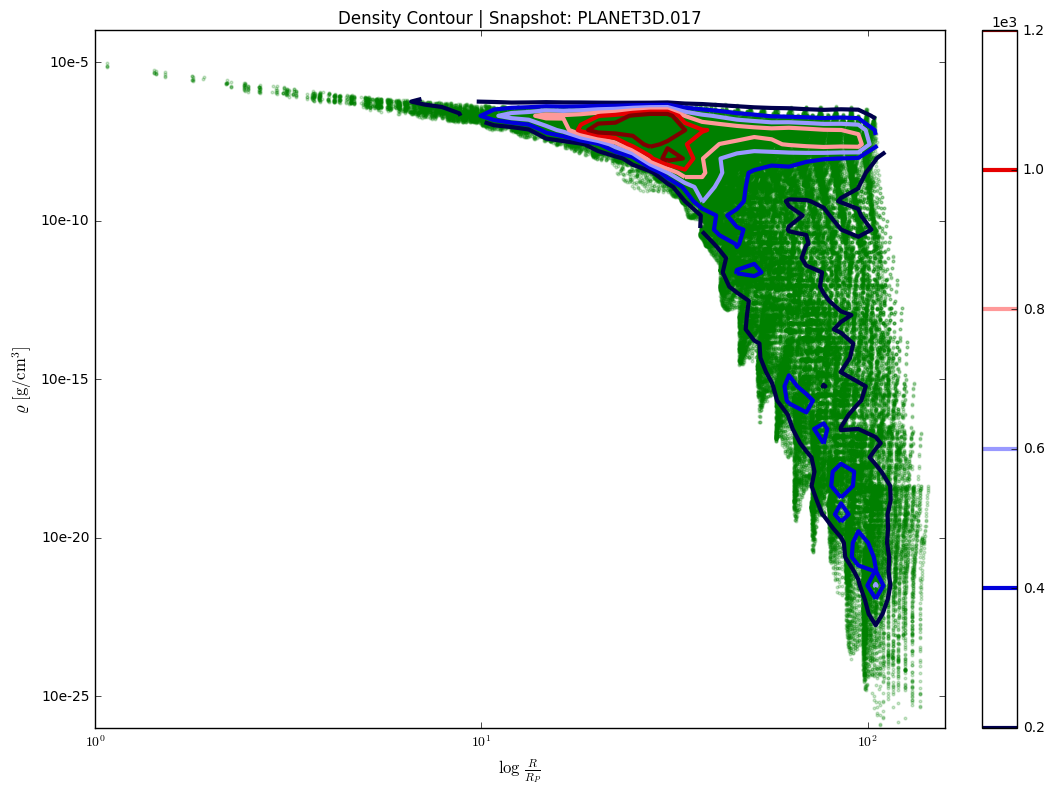

In [116]:
%matplotlib inline
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)

counts, xed, yed, image = ax.hist2d(np.log10(r_plan/r0_planet), np.log10(rho), bins=50, 
                                    cmap='seismic', range=[[0,2.2], [-26, -4]], cmin=1, alpha=0)
ax.scatter(np.log10(r_plan/r0_planet), np.log10(rho), c='g', edgecolors='face', s=15, marker='.', alpha=0.2)
con = ax.contour(counts.T, 6, extent=[xed.min(), xed.max(), yed.min(), yed.max()], linewidths=3, 
                 cmap='seismic', alpha=1)

cb = plt.colorbar(con, fraction=0.046, pad=0.04, orientation='vertical')
cb.formatter.set_powerlimits((0,0))  # setting the scientific notation of the color bar ticks
cb.update_ticks()

fig.canvas.draw()
#labels = [item.get_text() for item in ax.get_xticklabels()]
#labels = 
#test2 = [1,2,3,4,5]
xmajorLocator = mtick.MultipleLocator(1)
ax.xaxis.set_major_locator(xmajorLocator)
#minorLocator = mtick.LogLocator(10)
#ax.xaxis.set_minor_locator(minorLocator)
labels_test = [r'$10^0$', r'$10^0$',r'$10^1$', r'$10^2$']
ax.xaxis.set_ticklabels(labels_test)
ax.xaxis.set_major_formatter(mtick.FixedFormatter(labels_test))
#ax.xaxis.set_major_formatter(mtick.LogFormatterMathtext(10))

#set_labels = ['', r'$10e0$', '10e1', '10e2', '']
#for i,j in enumerate(ax.get_xticklabels()):
#    j.set_text(set_labels[i])
    
ymajorLocator = mtick.MultipleLocator(5)
ax.yaxis.set_major_locator(ymajorLocator)
ylabels = ['10e-25', '10e-25', '10e-20', '10e-15', '10e-10', '10e-5']
ax.yaxis.set_major_formatter(mtick.FixedFormatter(ylabels))

ax.set_ylabel('$\\varrho\ [\\mathrm{g/cm^3}]$', fontsize=12)
ax.set_xlabel('$\\mathrm{log}\ \\frac{R}{R_P}$', fontsize=12)
ax.set_title('Density Contour | Snapshot: ' + file)
#ax.set_xticklabels(labels_test)

#ax.set_xticks(test2)
#fig.savefig(plot_loc + 'testdensity.png', format='png')
plt.show()

In [ ]:
minorLocator = mtick.LogLocator

In [101]:
set_labels = ['', '10e0', '10e1', '10e2', '']

In [99]:
for i,j in enumerate(ax.get_xticklabels()):
    j.set_text(set_labels[i])
for i in label:
    print(i)

Text(0,0,'')
Text(0,0,'10e0')
Text(1,0,'10e1')
Text(2,0,'10e2')
Text(2,0,'')


In [95]:
label = ax.get_xticklabels()
for i in label:
    print(i)

Text(0,0,'0.0')
Text(0,0,'10e0')
Text(1,0,'10e1')
Text(2,0,'10e2')
Text(2,0,'2.0')


In [113]:
plt.contour?

In [119]:
rho_levels

[200.0, 410.0, 620.0, 830.0, 1040.0, 1250.0]